In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm

import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import random

from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm



prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "BII_NLKmode_3d_start.lat"  #file is provided


x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp

def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0):
    ps = gtpsa.ss_vect_double(0.0)

    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.x+=mu_y
    ps.py+=mu_py
    return ps


acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

#Description of NLK
nlkfk = acc.find("KDNL1KR", 0)
nlk_name = nlkfk.name
nlk, nlkf_intp = create_nlk_interpolation(nlk_name)
nlkfk.set_field_interpolator(nlkf_intp)

In [5]:
def effect_on_stored_ring(x_list,px_list,return_plot = True,when_activate_NLK=0,kicker_strength=1.0):
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    
    nlkf_intp.set_scale(kicker_strength)
    
    X,Y = np.meshgrid(x_list,px_list)

    Z = np.zeros((len(x_list),len(px_list)))
        
    for i in range(len(x_list)):
        for j in range(len(px_list)):
            ps = create_state_space_vector(mu_x=x_list[i],mu_px=px_list[j])

            result = acc.propagate(calc_config, ps,0,201)   #propagate to index 201, where NLK is located
            old_px = float(ps.px)  #save info
            result = acc.propagate(calc_config, ps,201,1)   #propagate to after NLK
            Z[i,j]= ps.px-old_px   #save absolute difference
     
    if return_plot == False:
        return X,Y,Z
    
    plt.figure(figsize=(9,5))
    plt.pcolormesh(X*1000,Y*1000,Z.T*1000,shading='auto')
    
    plt.colorbar()

    plt.title(f"px-change on stored electrons, by NLK")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()

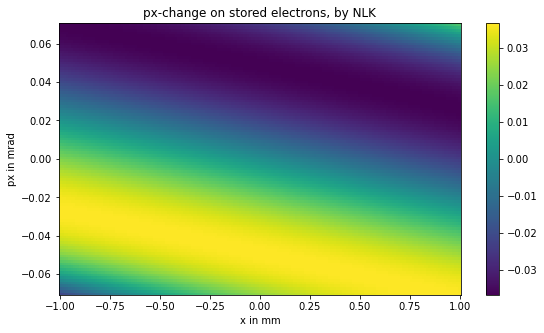

In [6]:
effect_on_stored_ring(np.linspace(-1e-3,1e-3,200),np.linspace(-.7e-4,.7e-4,100),kicker_strength = 1)